In [1]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy

In [2]:
data_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_ccube.fits')
cmap_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_cmap.fits')
model_file = get_pkg_data_filename('allsky_counts_model.fits')
diffuse_file = get_pkg_data_filename('diffuse_only.fits')
point_file = get_pkg_data_filename('point_only.fits')
exp_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_expcube1.fits')

In [3]:
data_hdu = fits.open(data_file)[0]
cmap_hdu = fits.open(cmap_file)[0]
model_hdu = fits.open(model_file)[2]
exp_hdu = fits.open(exp_file)[0]

In [4]:
exp_hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 3600 / length of data axis 1                          
NAXIS2  =                 1800 / length of data axis 2                          
NAXIS3  =                    2 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
TELESCOP= 'GLAST   '                                                            
INSTRUME= 'LAT     '                                                            
DATE    = '2021-12-14T12:23:

In [5]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [6]:
plt.rcParams['figure.dpi'] = 300

In [7]:
count_data = fits.getdata(data_file, ext=0)[0]
cmap_data = fits.getdata(cmap_file, ext=0)
model_data = fits.getdata(model_file, ext=0)
diffuse_data = fits.getdata(diffuse_file, ext=0)
point_data = fits.getdata(point_file, ext=0)
exp_data = fits.getdata(exp_file, ext=0)[1]
model_norm = model_data - numpy.min(model_data)

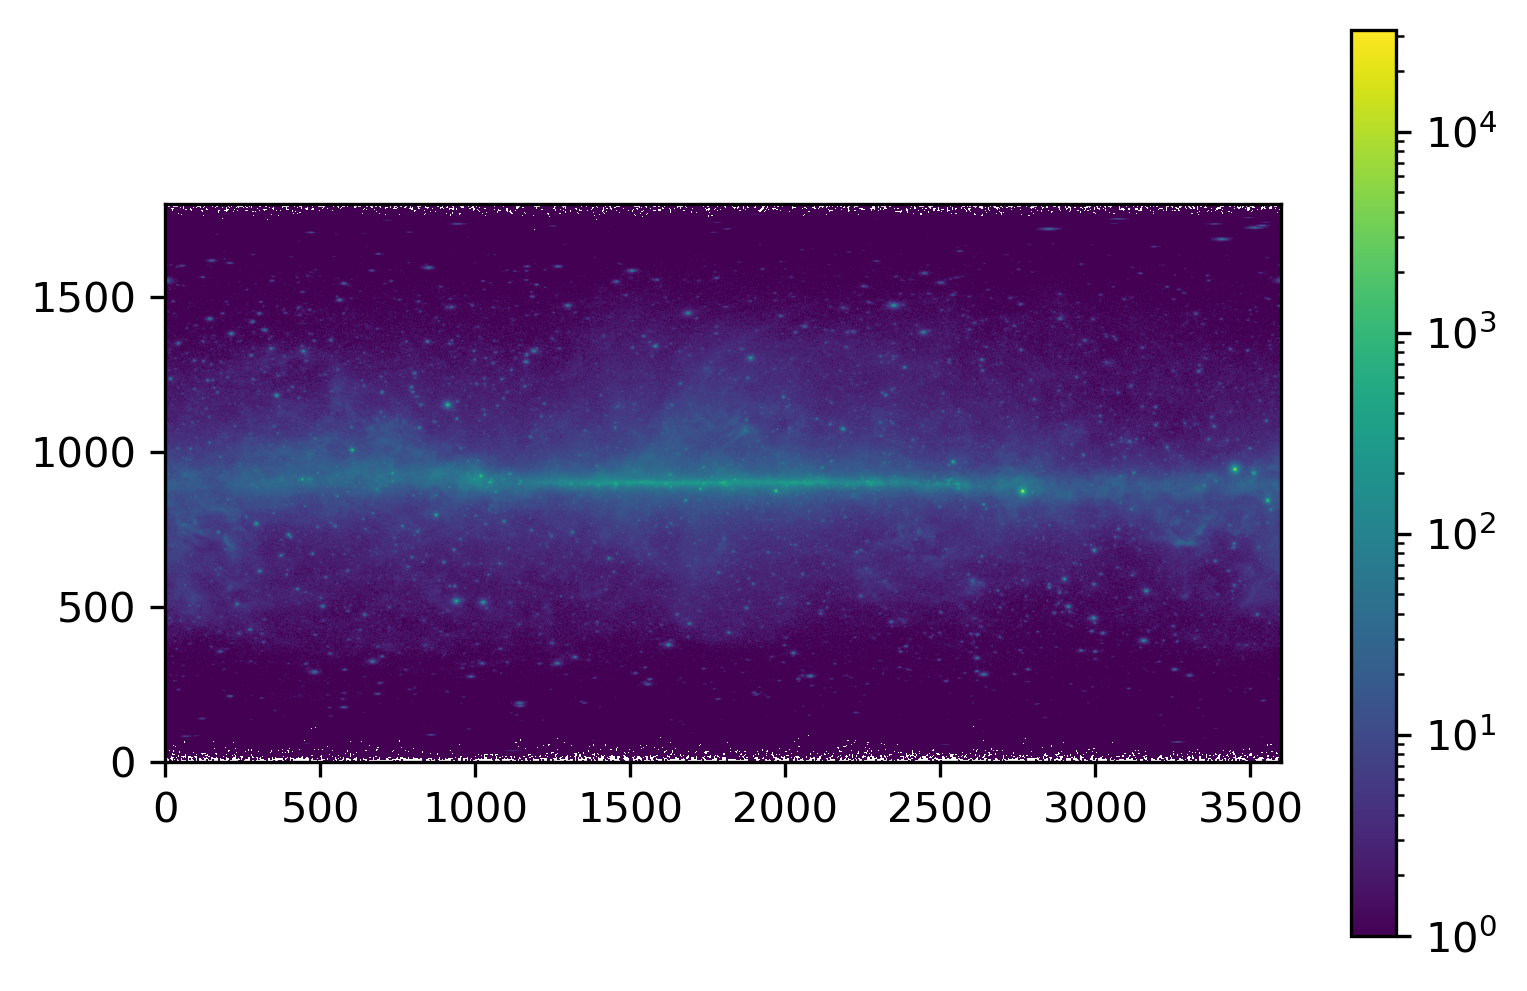

In [10]:
#plt.imshow(count_data, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
diff = plt.imshow(count_data, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [16]:
print(numpy.max(count_data), numpy.max(model_data))
print(numpy.min(count_data), numpy.min(model_data))
print(numpy.mean(count_data), numpy.mean(model_data))
print(numpy.max(model_norm), numpy.min(model_norm))
print(numpy.max(exp_data))

32031 48166.207
0 0.0016366403
5.025956790123457 20.96125
48166.207 0.0
715351100000.0


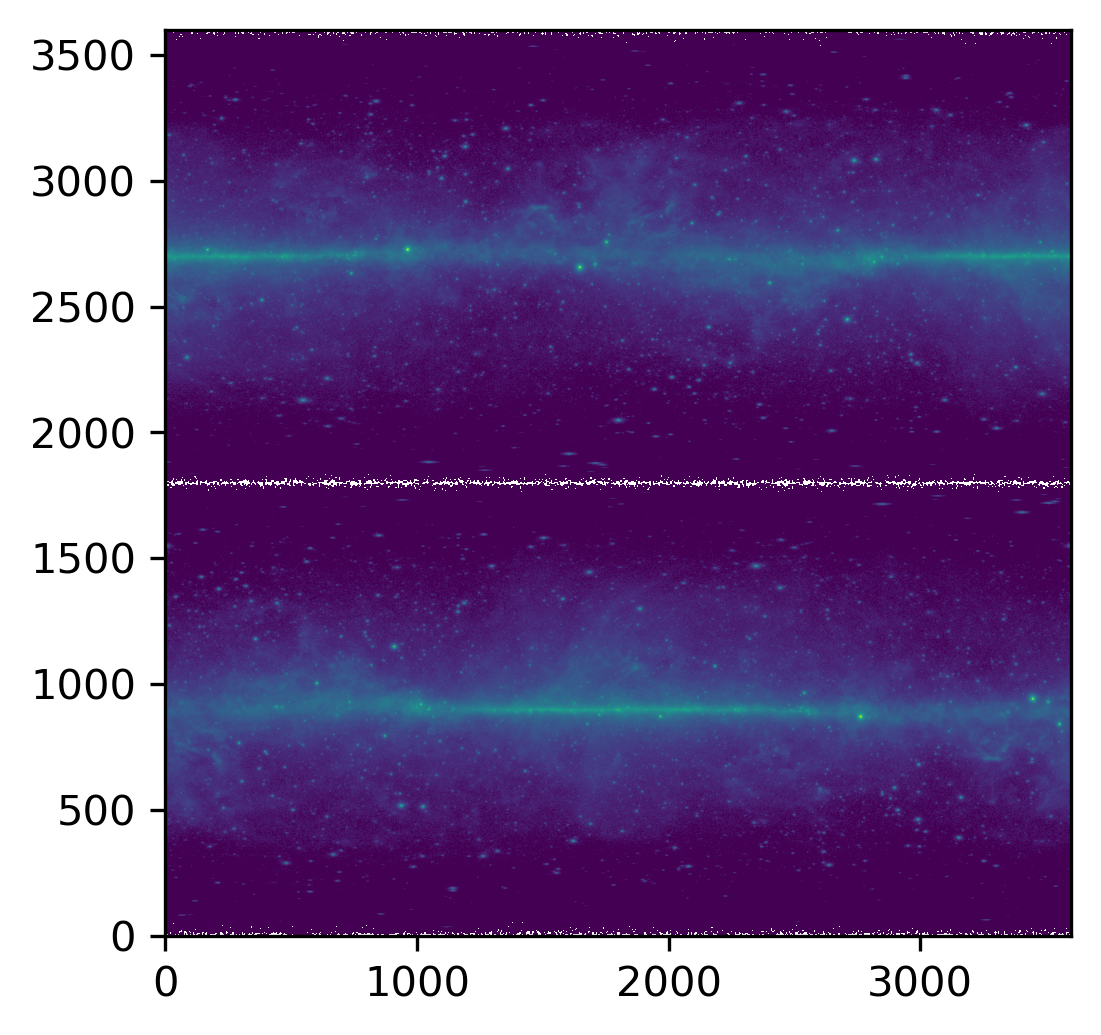

In [19]:
stacked = numpy.vstack((count_data, numpy.flipud(numpy.roll(count_data,1800,1))))
diff = plt.imshow(stacked, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())

In [120]:
def index_sphere(arr, row, col):
    h, w = numpy.shape(arr)
    wq, wr = divmod(col, w)
    hq, hr = divmod(row, h)
    if (hq % 2 == 0):
      return (hr, wr)
    else:
        return (h - hr - 1, (wr + w // 2) % w)
index_sphere(count_data, 1800, 1799)

(1799, 1800)

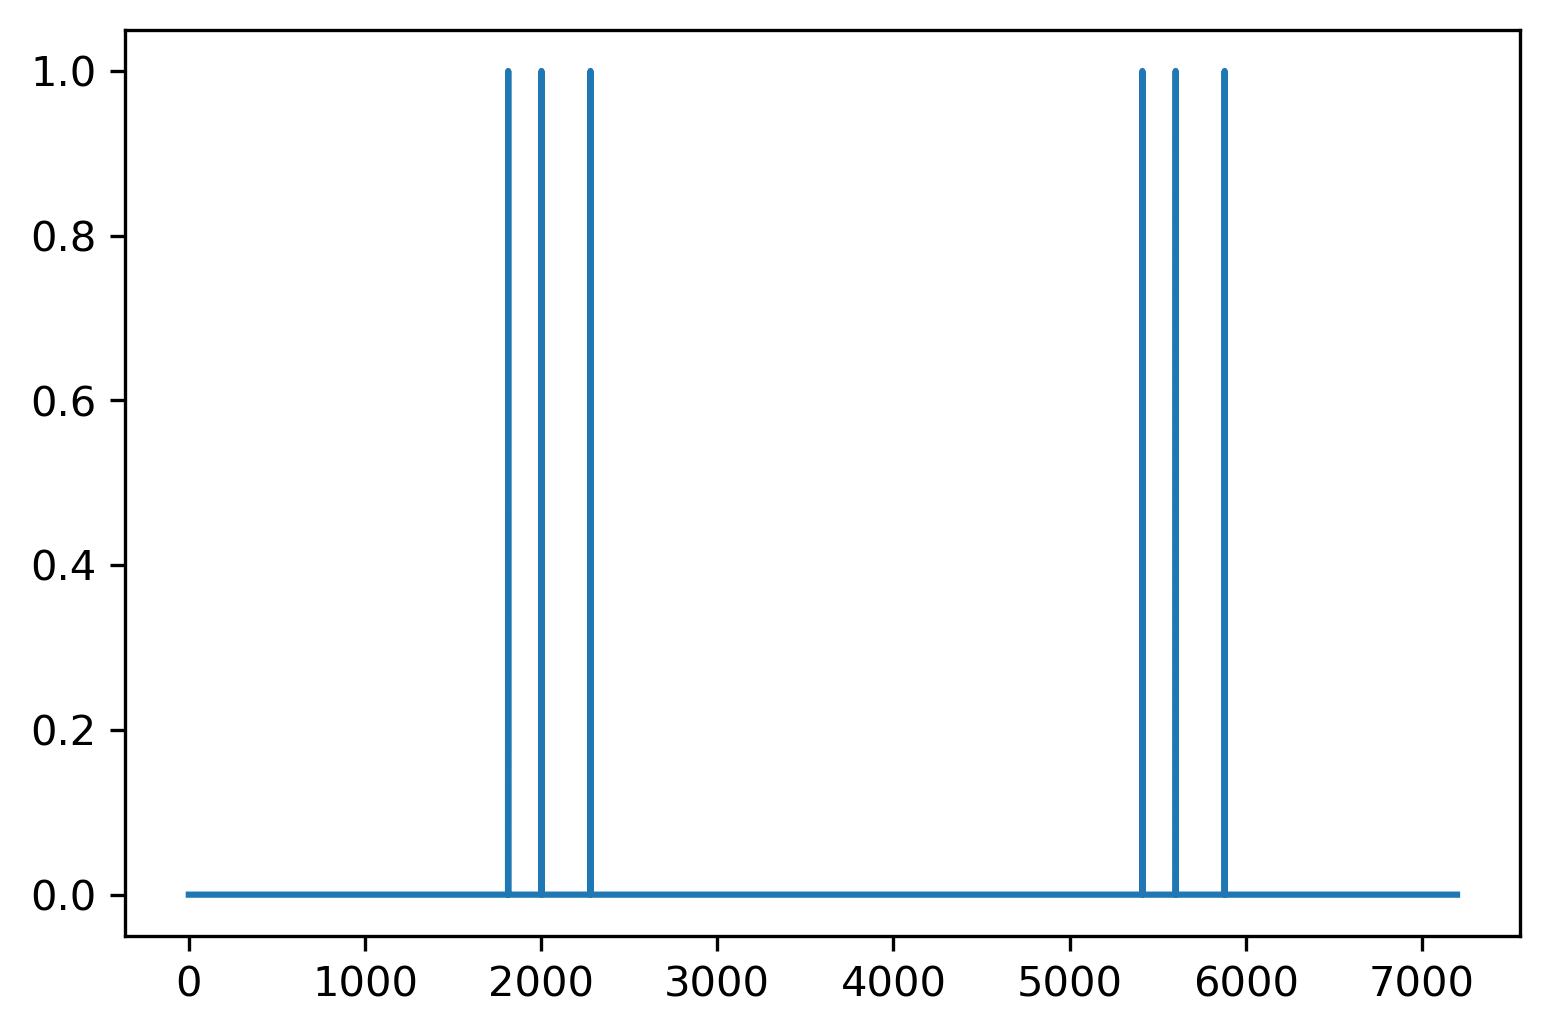

In [131]:
def sphere_row(arr, row):
    h, w = numpy.shape(arr)
    hq, hr = divmod(row, h)
    if (hq % 2 == 0):
        r = arr[hr, :]
        return numpy.concatenate((r,r))
    else:
        r = numpy.roll(arr[h - hr - 1, :], w // 2)
        return numpy.concatenate((r,r))

In [187]:
def haar_rows(J, j, arr, row):
    s = 2**(J - j - 1)
    xx = sphere_row(arr, row)
    dx = sphere_row(arr, row+s)
    xr = numpy.roll(xx, s)
    dr = numpy.roll(dx, s)
    return (xx, xr, dx, dr)

In [171]:
def haar_j(J, j, arr):
    N = 2**J
    rows, cols = arr.shape
    sh = (rows, cols)
    a = numpy.empty(sh, int)
    h = numpy.empty(sh, int)
    v = numpy.empty(sh, int)
    d = numpy.empty(sh, int)
    for row in range(rows):
        xx, xr, dx, dr = haar_rows(J, j, arr, row)
        h1 = numpy.add(xx, dx)
        h2 = numpy.add(xr, dr)
        v1 = numpy.add(xx, xr)
        v2 = numpy.add(dx, dr)
        d1 = numpy.add(xx, dr)
        d2 = numpy.add(xr, dx)
        a[row, :] = numpy.add(h1, h2)[0:cols]
        h[row, :] = numpy.subtract(h1, h2)[0:cols]
        v[row, :] = numpy.subtract(v1, v2)[0:cols]
        d[row, :] = numpy.subtract(d1, d2)[0:cols]
    return (a, h, v, d)

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

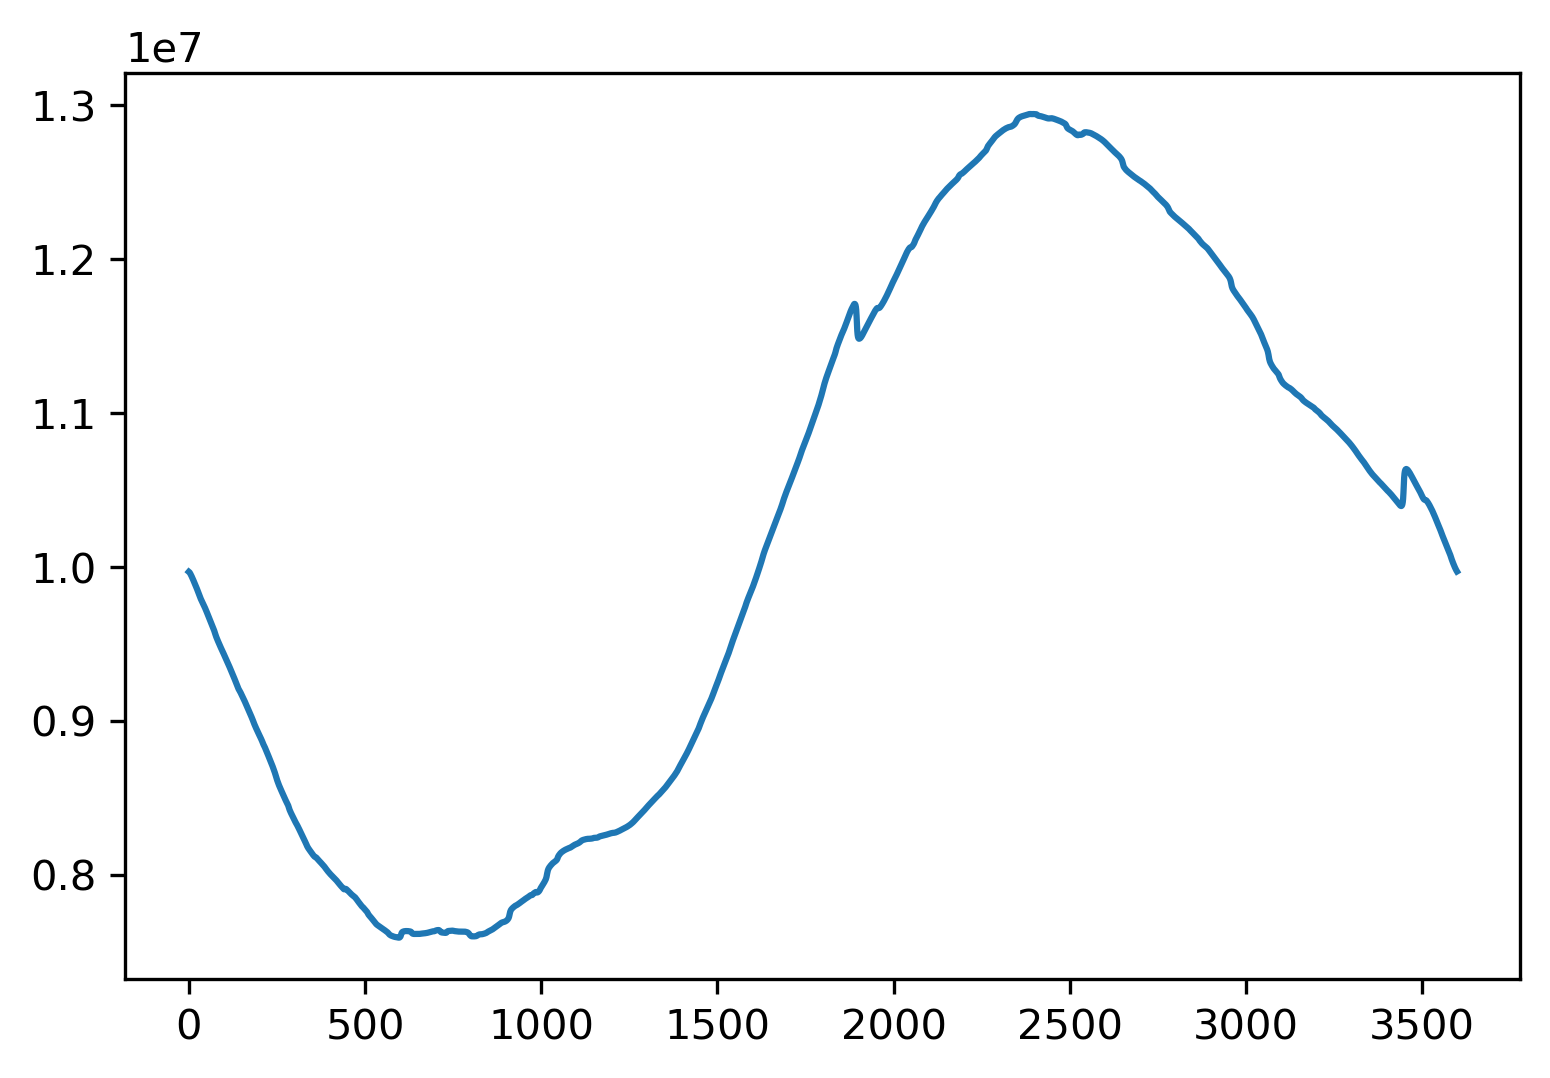

In [194]:
plt.plot(a1[900, :])

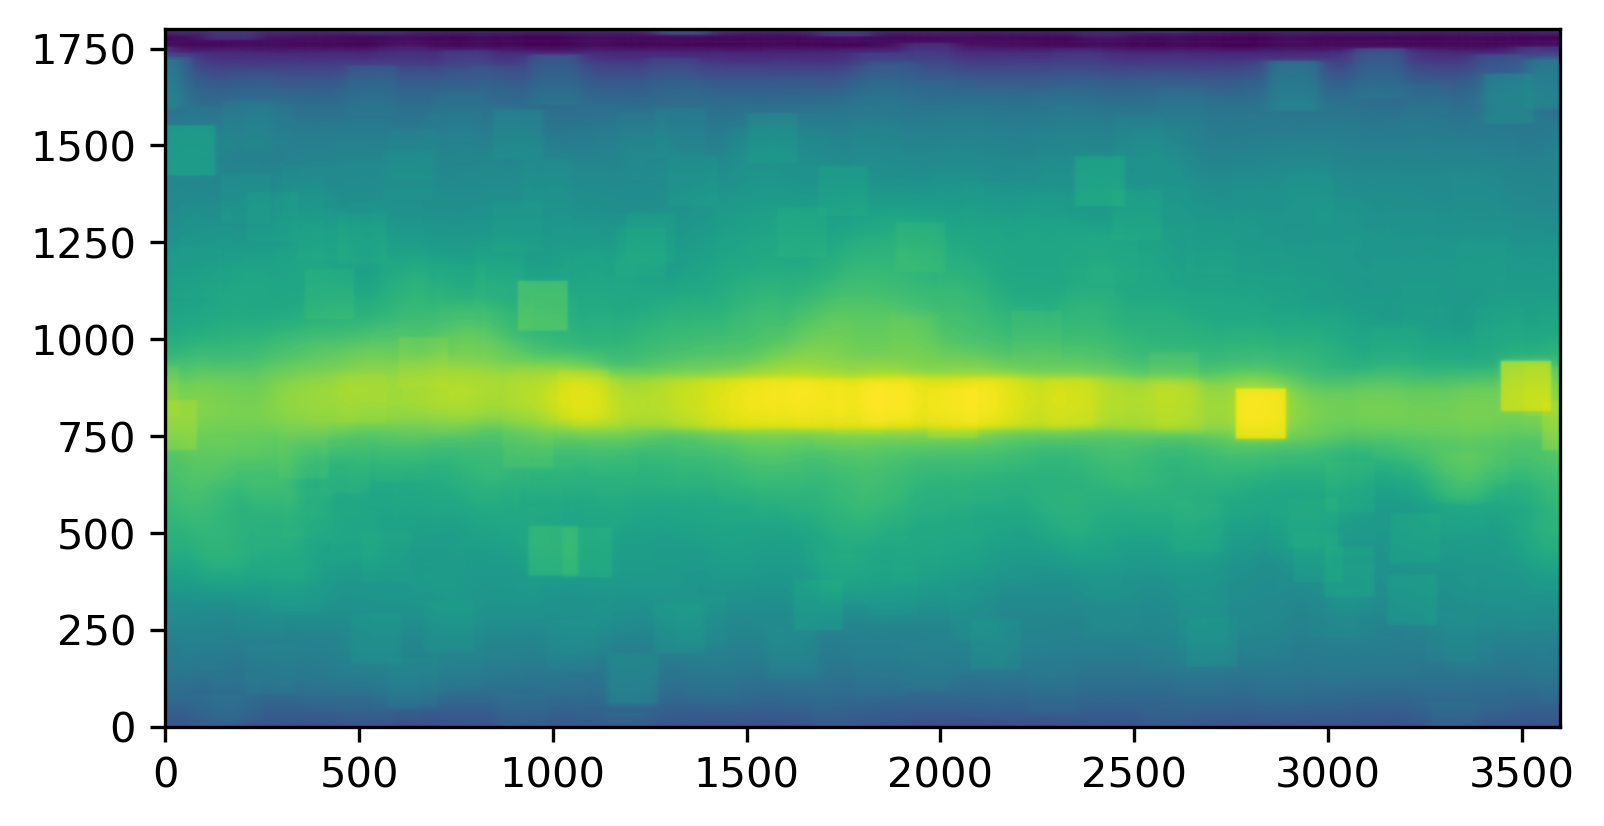

In [204]:
plt.imshow(a5, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')